# Part 1 - Single Subject Classification

Import libraries

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.ndimage import convolve1d
import seaborn as sns

### 1. Visualize and Preprocess the Data for Subject 2

Load data

In [2]:
data = loadmat("s2/S2_A1_E1")

emg = data['emg']
n_samples = emg.shape[0]
n_channels = emg.shape[1]
fs = 2000

print(f"There are {n_samples} timepoints")
print(f"There are {n_channels} channels")

There are 100686 timepoints
There are 10 channels


Visualize data for all channels

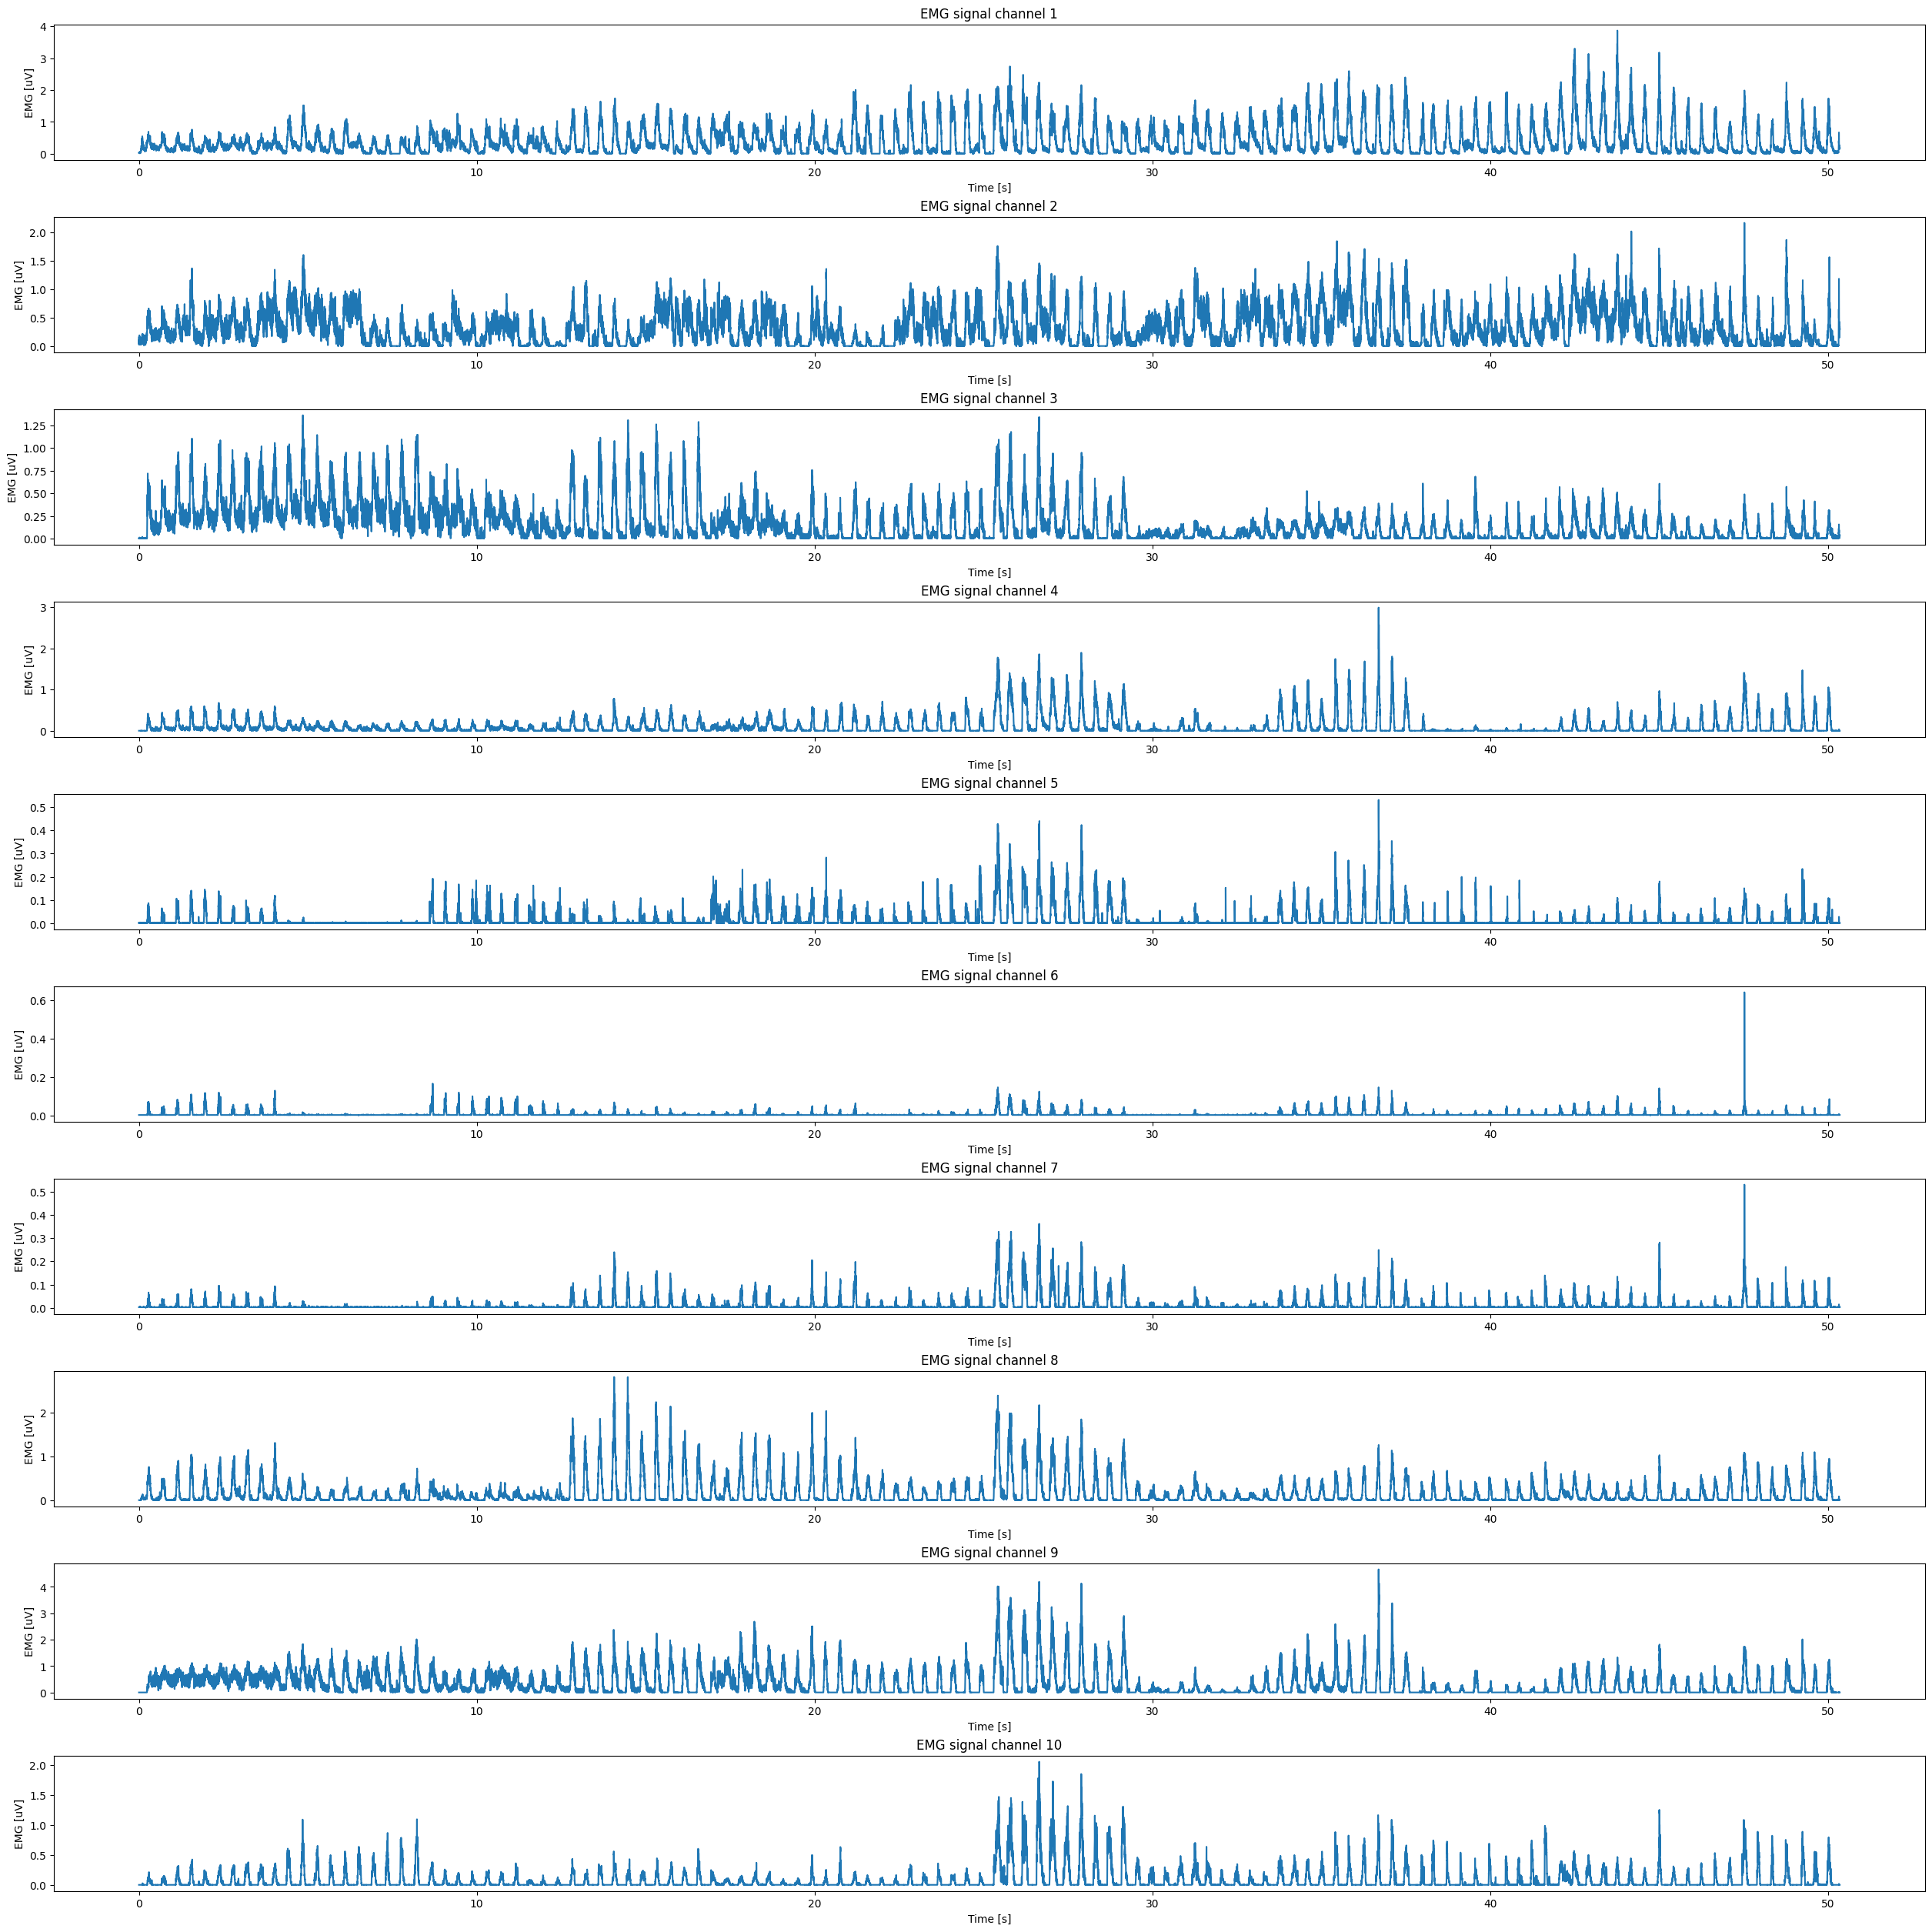

In [3]:
times = np.arange(0, n_samples/fs, 1/fs)
fig, axes = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(25,25)) 
for channel in range(n_channels):
    axes[channel].plot(times, emg[:, channel])
    axes[channel].set_xlabel("Time [s]")
    axes[channel].set_ylabel("EMG [uV]")
    axes[channel].set_title(f"EMG signal channel {channel+1}")

Preprocessing (data already band-passed and rectfied)

In [4]:
# Envelope the signal with a moving average filter
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

# Initialize data structure for the envelope
stimulus = data['restimulus']
repetition = data['rerepetition']

n_stimuli = len(np.unique(stimulus))-1
n_repetitions = len(np.unique(repetition))-1

emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimulus_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimulus_idx in range(n_stimuli)]

for stimulus_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimulus_idx+1, repetition == repetition_idx+1).flatten()
        emg_windows[stimulus_idx][repetition_idx] = emg[idx, :]
        emg_envelopes[stimulus_idx][repetition_idx] = convolve1d(emg_windows[stimulus_idx][repetition_idx], mov_mean_weights, axis=0)

Visualize the signal after enveloping

C:\Users\marti\AppData\Local\Temp\ipykernel_23996\1735009357.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[ch].legend(loc="upper right", fontsize=6)


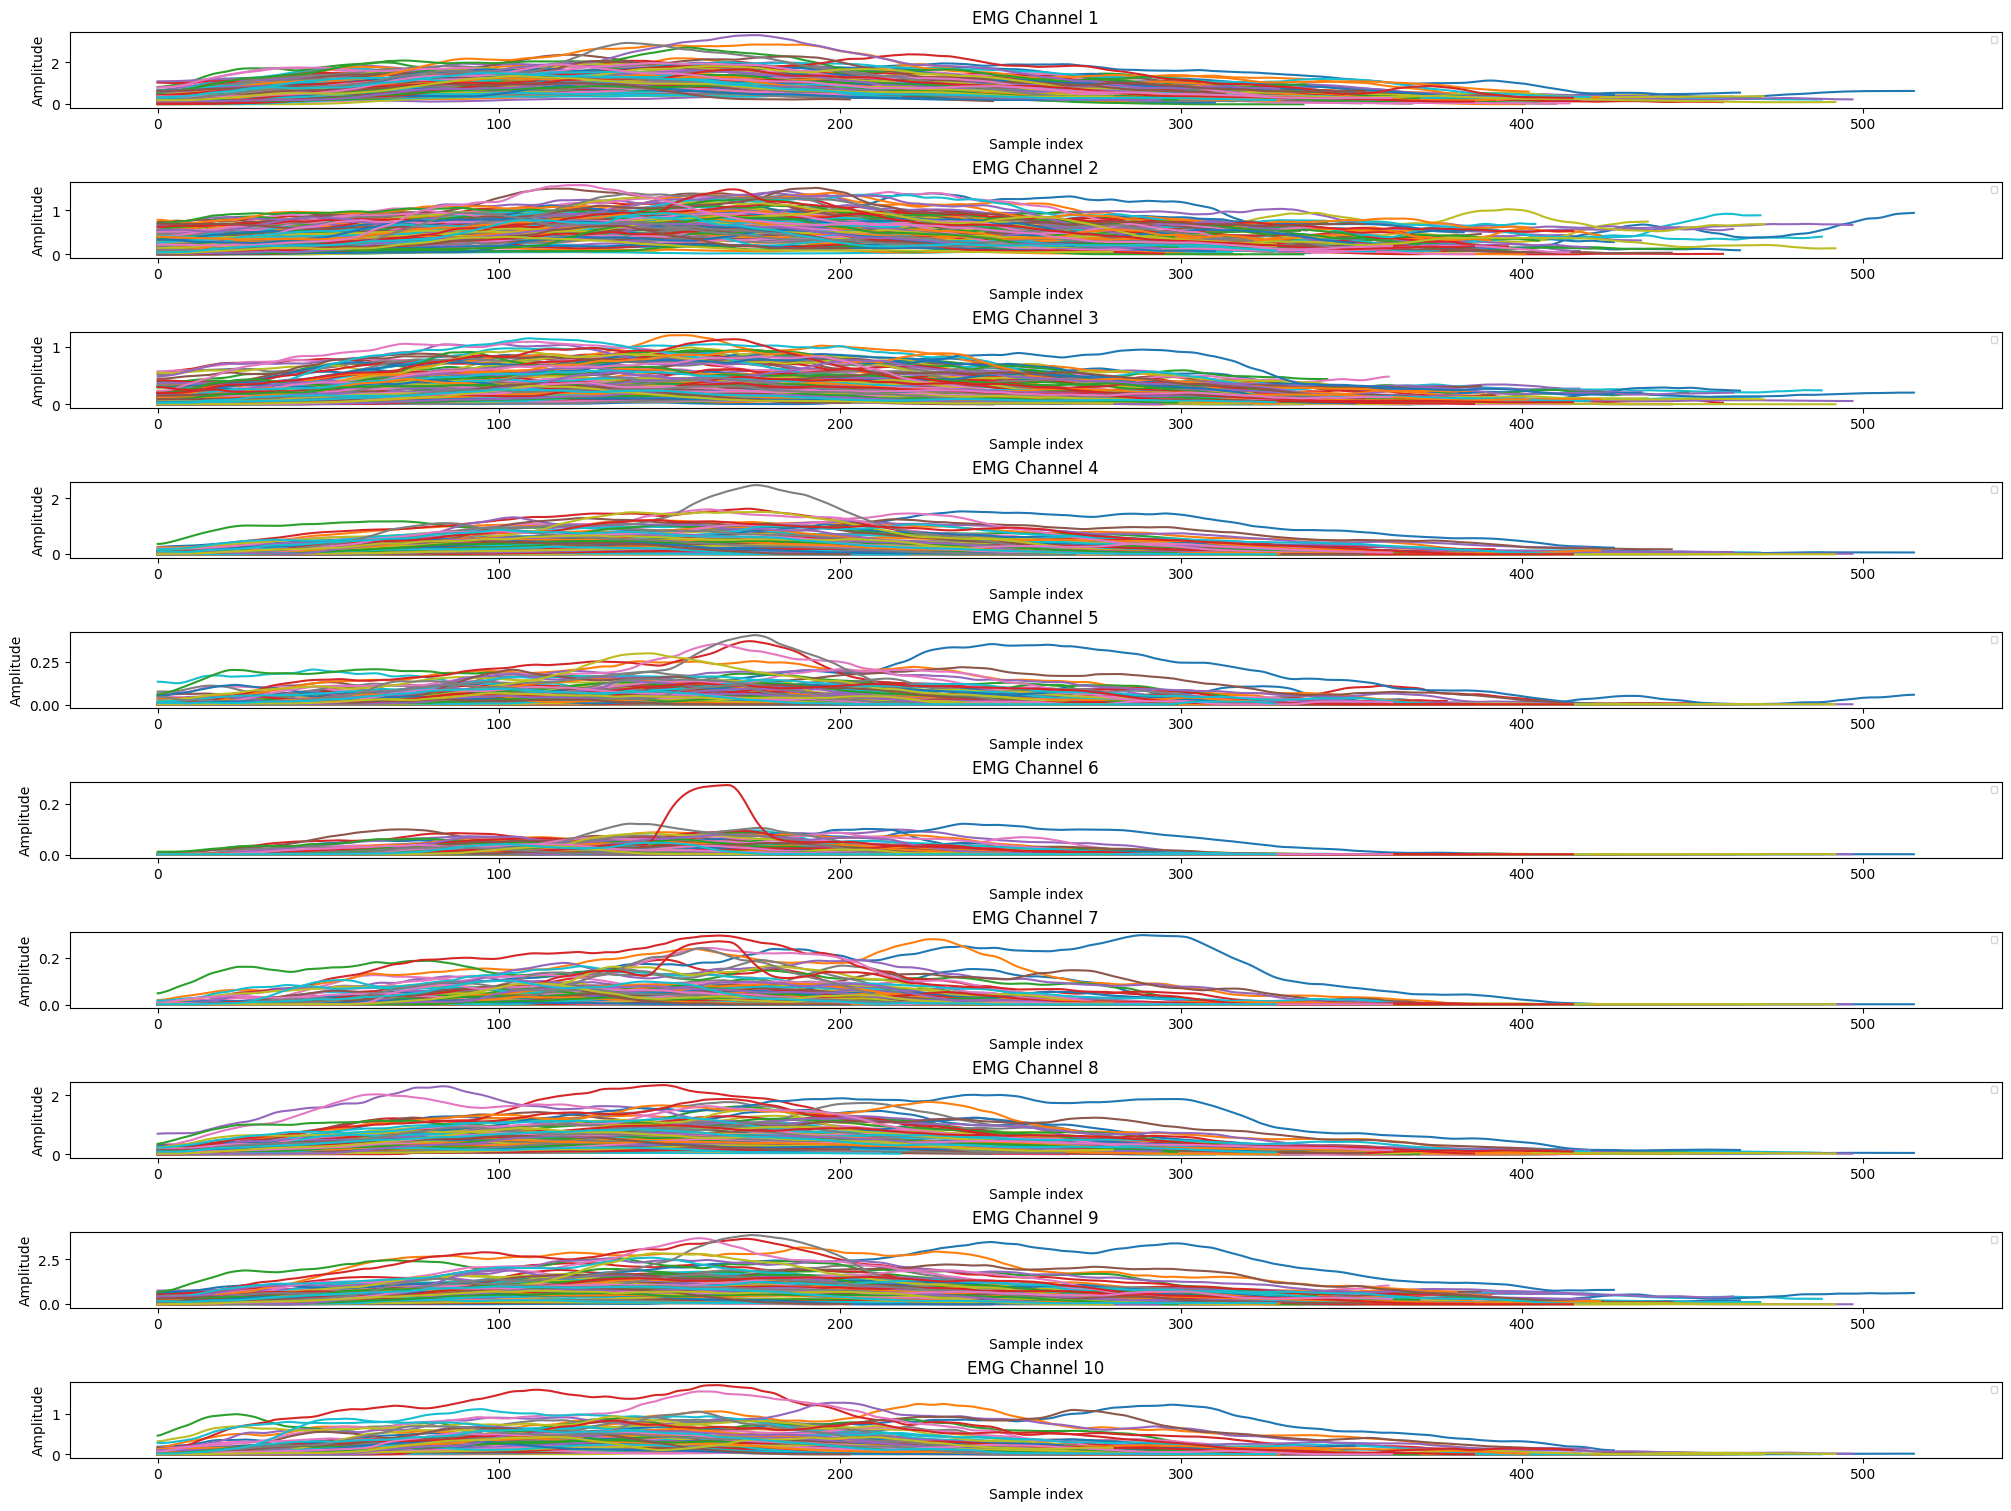

In [8]:
fig, axes = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(20, 15))

for ch in range(n_channels):
    for stim_idx in range(n_stimuli):
        for rep_idx in range(n_repetitions):
            trial_signal = emg_envelopes[stim_idx][rep_idx][:, ch]
            axes[ch].plot(trial_signal)
    axes[ch].set_title(f"EMG Channel {ch+1}")
    axes[ch].set_xlabel("Sample index")
    axes[ch].set_ylabel("Amplitude")
    axes[ch].legend(loc="upper right", fontsize=6)

Build dataset

In [ ]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    n_samples = n_stimuli * n_repetitions

    n_channels = emg.shape[1]
    n_features = sum(n_channels for feature in features)

    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    sample_idx = 0

    for i in range(n_stimuli):
        for j in range(n_repetitions):
            labels[sample_idx] = i+1
            sample_idx = i*n_repetitions + j
            feature_idx = 0
            selected_ts = np.logical_and(stimulus == i+1, repetition == j+1).squeeze()

            for feature in features:
                selected_features = np.arange(feature_idx, feature_idx+n_channels)
                dataset[sample_idx, selected_features] = feature(emg[selected_ts, :])
                feature_idx += n_channels   # fixed here
            
            sample_idx += 1

    return dataset, labels

### 2. Split the data into *training*, *validation* and *test* sets for the Subject

Define the features to build the dataset

In [17]:
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0) 
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum(
    ((x[1:-1] - x[:-2]) * (x[1:-1] - x[2:]) >= 0).astype(int),
    axis=0
)

Get the dataset

In [18]:
dataset, labels = build_dataset_from_ninapro(
    emg=emg,
    stimulus=stimulus,
    repetition=repetition,
    features=[mav, std, maxav, rms, wl, ssc]
)

print(f"Dataset dimension: {dataset.shape}")
print(f"Labels dimension: {labels.shape}")

Dataset dimension: (120, 60)
Labels dimension: (120,)


Splitting data

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2)

### 3. Extract Features from the *trials* and Visualize typical values

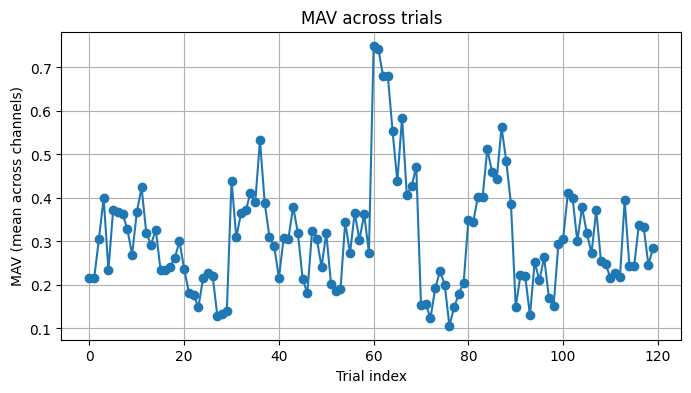

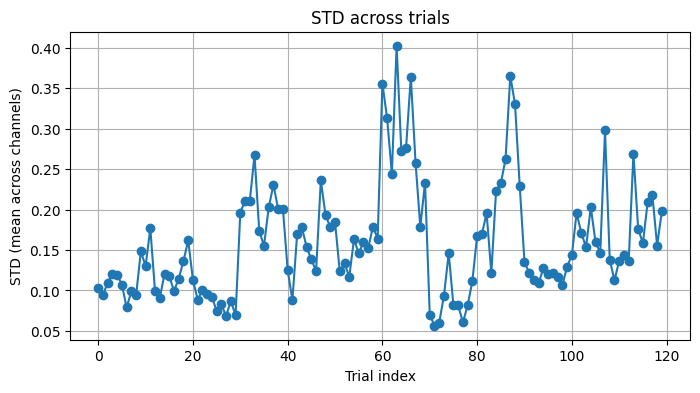

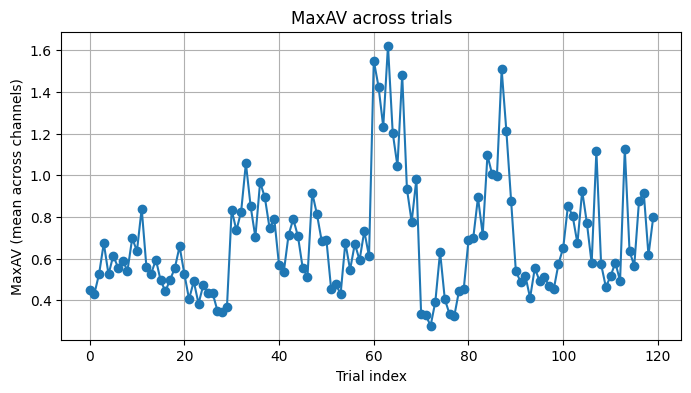

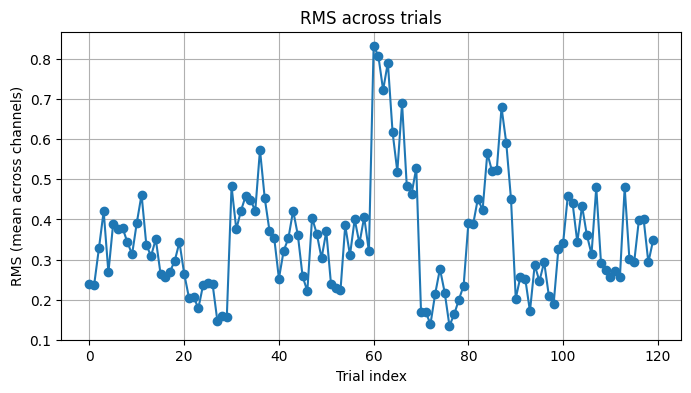

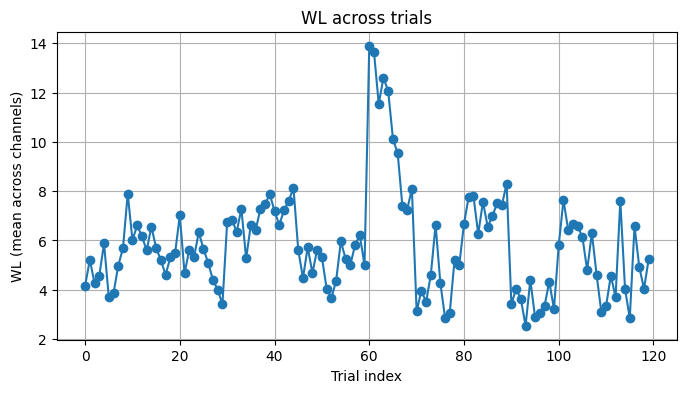

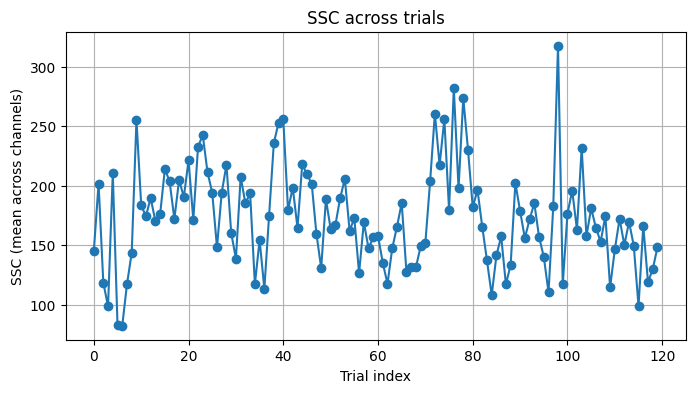

In [20]:
n_channels = emg.shape[1]

feature_names = ["MAV", "STD", "MaxAV", "RMS", "WL", "SSC"]

# Loop over features
for i, feat_name in enumerate(feature_names):
    start_col = i * n_channels
    end_col = start_col + n_channels
    
    # Extract feature for all trials
    feat_values = dataset[:, start_col:end_col]  
    
    # Compute mean across channels per trial
    feat_mean_per_trial = np.mean(feat_values, axis=1)
    
    plt.figure(figsize=(8,4))
    plt.plot(feat_mean_per_trial, marker='o')
    plt.title(f"{feat_name} across trials")
    plt.xlabel("Trial index")
    plt.ylabel(f"{feat_name} (mean across channels)")
    plt.grid(True)
    plt.show()


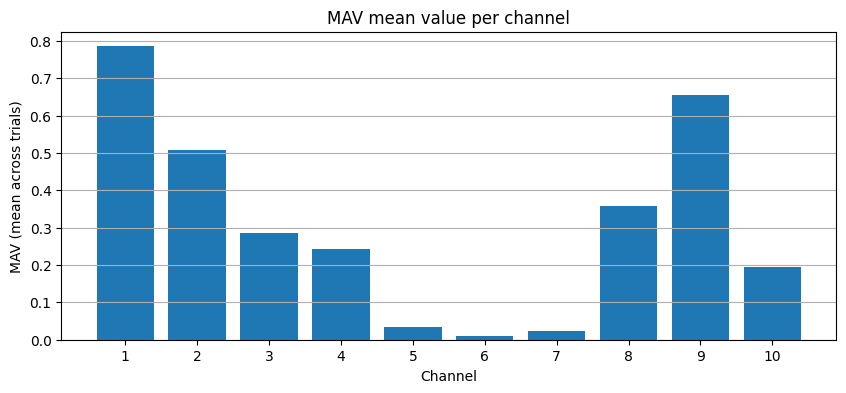

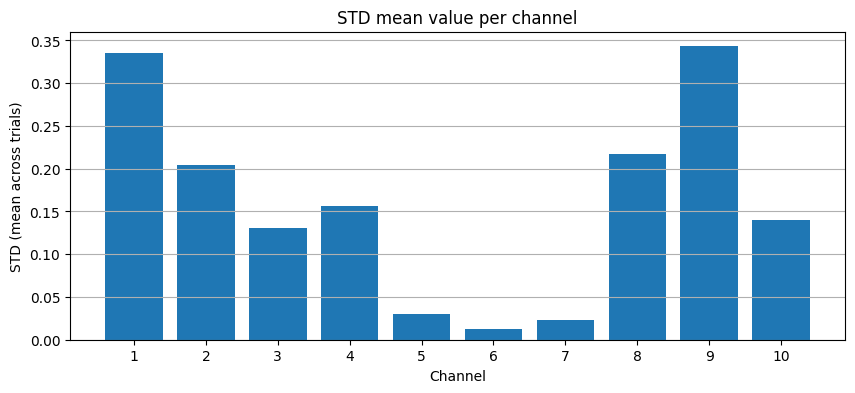

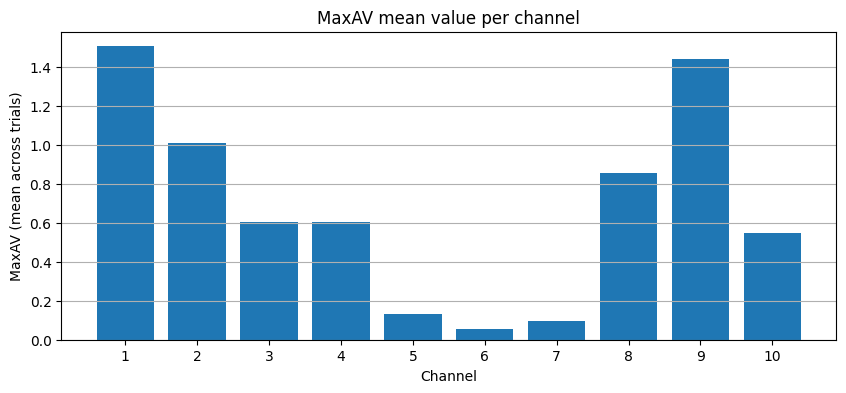

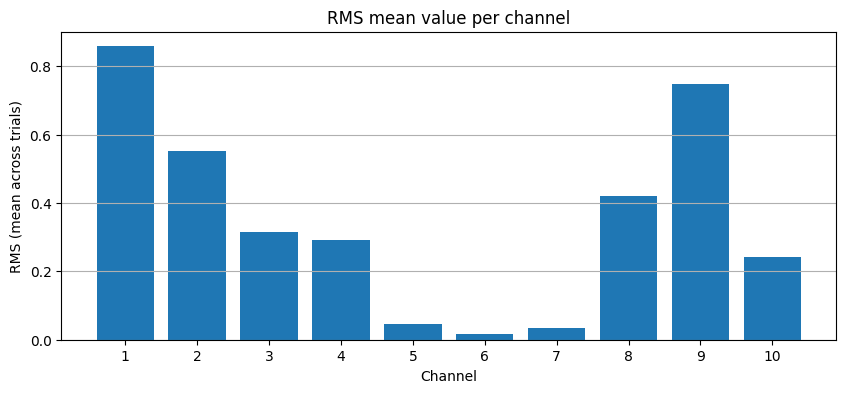

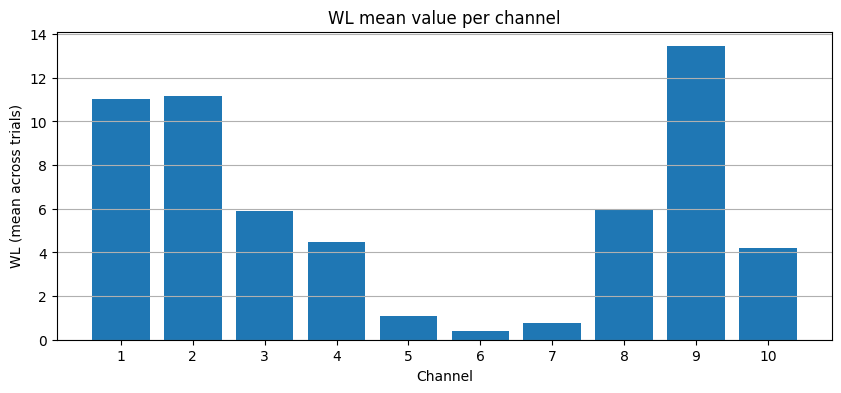

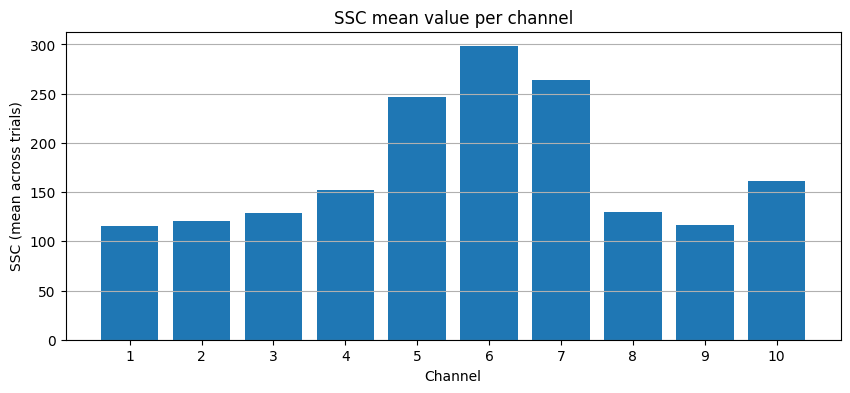

In [22]:
n_channels = emg.shape[1]
feature_names = ["MAV", "STD", "MaxAV", "RMS", "WL", "SSC"]

# Loop over features
for i, feat_name in enumerate(feature_names):
    start_col = i * n_channels
    end_col = start_col + n_channels
    
    # Extract feature for all trials
    feat_values = dataset[:, start_col:end_col]  # shape: (n_trials, n_channels)
    
    # Compute mean across trials for each channel
    feat_mean_per_channel = np.mean(feat_values, axis=0)  # shape: (n_channels,)
    
    plt.figure(figsize=(10,4))
    plt.bar(range(1, n_channels+1), feat_mean_per_channel)
    plt.xticks(range(1, n_channels+1))
    plt.xlabel("Channel")
    plt.ylabel(f"{feat_name} (mean across trials)")
    plt.title(f"{feat_name} mean value per channel")
    plt.grid(axis='y')
    plt.show()


### 4. Perform classification on the data of Subject 2

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Z-score normalization
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train) 
X_test_z = scaler.transform(X_test)   

# Training
clf = SVC(kernel='rbf')         # We can also use 'linear', 'poly'
clf.fit(X_train_z, y_train)

# Inference
y_pred = clf.predict(X_test_z)

Hyperparameters optimization

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1e-3, 1e-2, 0.1, 1],
    'kernel': ['rbf', 'poly', 'linear'],
    'class_weight': ['balanced']
}

grid = GridSearchCV(SVC(), param_grid)
grid.fit(X_train_z, y_train)

print(f"Best estimator: {grid.best_estimator_}")
print("Best parameters:", grid.best_params_)

Best estimator: SVC(C=0.1, class_weight='balanced', gamma=0.001, kernel='linear')
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.001, 'kernel': 'linear'}


Cross validation (to complete)

In [33]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train_z, y_train, scoring='accuracy', cv=5)

### 5. Evaluate the Performance (a bit suspicious)

Accuracy score: 0.9583333333333334
Balanced accuracy score: 0.9545454545454546
Avergae F1 score over classes: 0.9393939393939393


Text(0.5, 23.52222222222222, 'Predicted label')

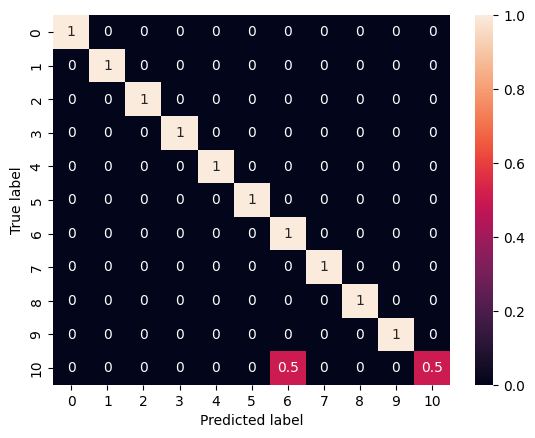

In [34]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Accuracy 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

# Balanced accuracy 
bal_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced accuracy score: {bal_accuracy}")

# F1
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Avergae F1 score over classes: {f1_macro}")

# Confusion matrix
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax) 
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

### 6. Perform Feature Selection or Dimensionality Reduction to improve Performance